In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [3]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [4]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [5]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [6]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej
df = df.sort_values(['Data'], ascending=[True])

In [7]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

In [8]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [16]:
class Portfel:
    """Portfel zwrotów logarytmicznych zbudowany na podstawie odsetku ropy w portfelu (reszta to gaz).
    Pozwala łatwo dostać podstawowe metryki.
    """
    def __init__(self,
                 df: pd.DataFrame,
                 odsetek_ropy: float=.5) -> None:
        self.odsetek_ropy = odsetek_ropy
        self.odsetek_gazu = 1 - odsetek_ropy
        self.usd_na_gaz = np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
        self.usd_na_rope = np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()
    
    @property
    def mean(self):
        return self.odsetek_ropy*self.usd_na_rope.mean() + \
              self.odsetek_gazu*self.usd_na_gaz.mean()
    
    @property
    def var(self):
        return self.odsetek_ropy*self.odsetek_ropy*self.usd_na_rope.var() + \
            self.odsetek_gazu*self.odsetek_gazu*self.usd_na_gaz.var() + \
            2*self.odsetek_gazu*self.odsetek_ropy*self.usd_na_gaz.std()*\
            self.usd_na_rope.std()*np.corrcoef(self.usd_na_gaz[1:],
                                                     self.usd_na_rope[1:])[1,0]
    
    @property
    def risk(self):
        """Just a standard deviation"""
        return np.sqrt(self.var)
    
    @property
    def corr(self):
        return np.corrcoef(self.usd_na_gaz[1:], self.usd_na_rope[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.usd_na_rope[1:], q)*self.odsetek_ropy + \
            np.quantile(self.usd_na_gaz[1:], q)*self.odsetek_gazu
    
    def __getitem__(self, key):
        return self.usd_na_rope[1:][key]*self.odsetek_ropy + \
            self.usd_na_gaz[1:][key]*self.odsetek_gazu

## Zad 1

In [17]:
print("Średnia gazu: ", df['przyrosty_log_gaz'].mean())
print("Odchylenie standardowe gazu: ", df['przyrosty_log_gaz'].std())
print("Średnia ropy: ",df['przyrosty_log_ropa'].mean())
print("Odchylenie standardowe ropy:", df['przyrosty_log_ropa'].std())

Średnia gazu:  -0.0002813984837701097
Odchylenie standardowe gazu:  0.035355435898576204
Średnia ropy:  3.163628003118414e-05
Odchylenie standardowe ropy: 0.024704816898006354


### a)

Zakładam, że rzeczywiste wagi to .8 ropy .2 gazu. Można łatwo zmienić w deklaracji poniżej.

In [18]:
p = Portfel(df, odsetek_ropy=.8)
portfel_values = [p[i] for i in range(len(df['przyrosty_log_ropa'][1:])-1)]

In [19]:
print("Stopa zwrotu portflea: ", p.mean)

Stopa zwrotu portflea:  -3.097067272907462e-05


std

In [25]:
print("Ryzyko portfela: ", p.risk)

Ryzyko portfela:  0.02189897148559016


corr

In [24]:
p.corr

0.13937114135785103

### b)

In [27]:
space = np.linspace(0, 1, 100)
means = []
risks = []
for i in space:
    p = Portfel(df, odsetek_ropy=i)
    means.append(p.mean)
    risks.append(p.risk)

Text(0.5, 0, 'Odsetek ropy w portfelu')

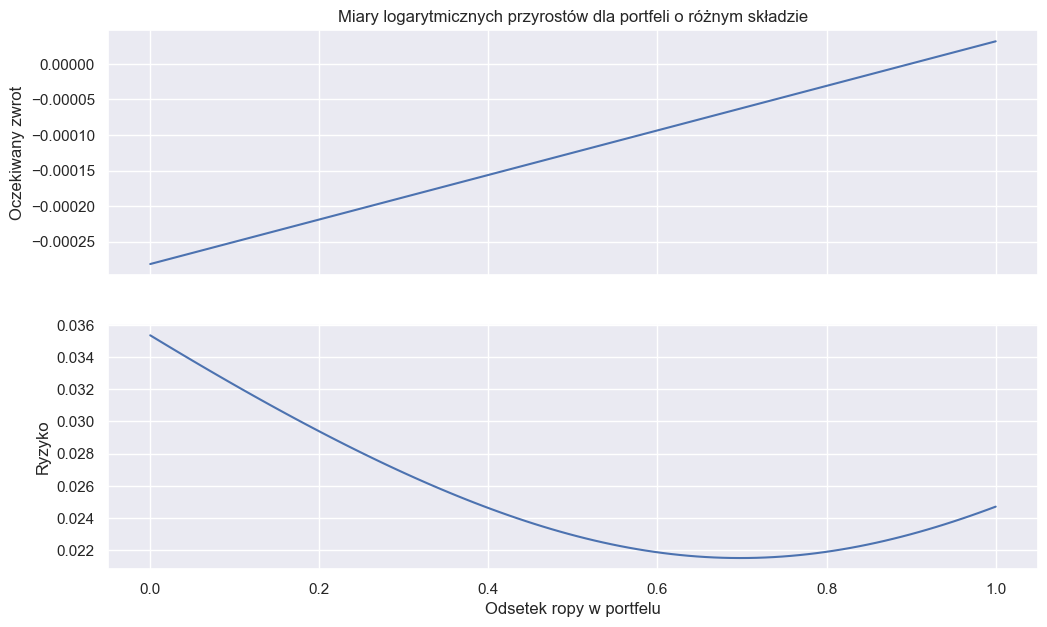

In [29]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
axs[1].plot(space, risks)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')

### c)

In [32]:
def ryzyko(odsetek_ropy):
    """Func to be optimized by opt.minimize"""
    return Portfel(df, odsetek_ropy=odsetek_ropy).risk

In [33]:
opt.minimize(ryzyko, .6978, method='Powell', options={'xtol': 1e-14, 'ftol': 1e-14})

   direc: array([[1.]])
     fun: array(0.02151004)
 message: 'Optimization terminated successfully.'
    nfev: 31
     nit: 2
  status: 0
 success: True
       x: array([0.69781425])

In [34]:
x = 0.69781425

In [35]:
print((1 - x))
print((1 - x)/x)

0.30218575000000003
0.4330461150657213


In [38]:
optimal_wallet = Portfel(df, odsetek_ropy=x)

Stosunek ropy do gazu w protfelu o minimalnym ryzku wynosi 1 : 0.433

LUB

30.218575% gazu i 69.781425% ropy

Ryzyko wynosi 0.00046268

Text(0.5, 0, 'Odsetek ropy w portfelu')

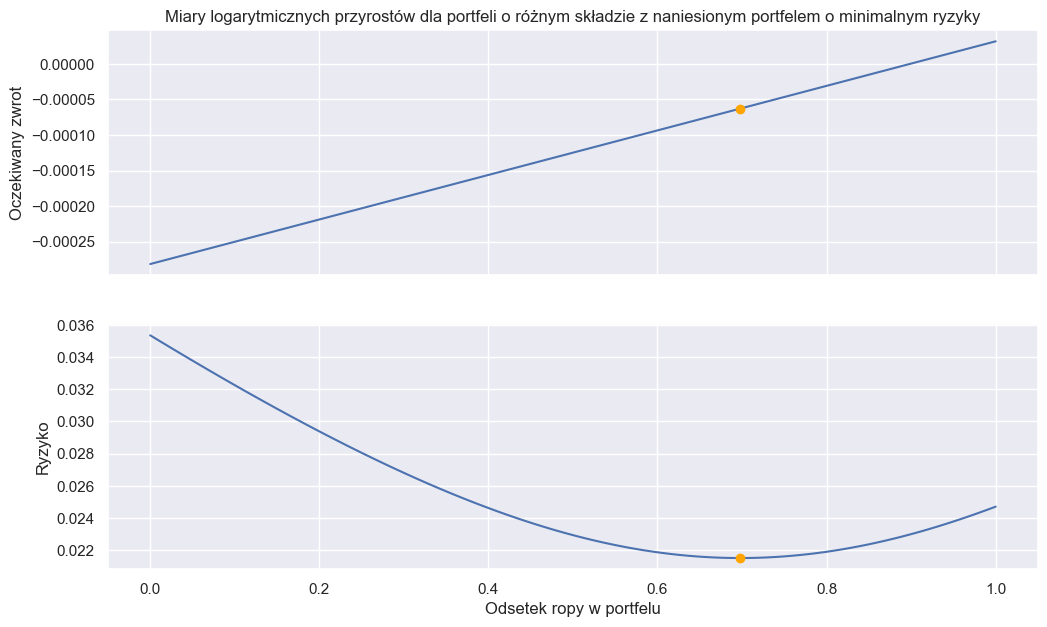

In [40]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means, zorder=1)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym'
                 ' składzie z naniesionym portfelem o minimalnym ryzyky')
axs[0].scatter(x, optimal_wallet.mean, color="orange", zorder=2)
axs[1].plot(space, risks, zorder=1)
axs[1].scatter(x, optimal_wallet.risk, c="orange", alpha=1, zorder=2)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')

### d)

In [108]:
ustalona_stopa_zwrotu = .000005

In [112]:
for i in np.linspace(0,1,1000000):
    filter(Portfel())

array([0.000000e+00, 1.000001e-06, 2.000002e-06, ..., 9.999980e-01,
       9.999990e-01, 1.000000e+00])